In [1]:
# Basic imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

# preprocessing and split
from sklearn.model_selection import train_test_split as split
from sklearn.preprocessing import StandardScaler

# models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier , VotingClassifier, StackingClassifier

# Scores and reports
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Make the data frame
def Makedata(Names):
    li = []
    for i,name in enumerate(Names):

        all_files = glob.glob(name + "/*.csv")
        labels = ["Spontan", "Sync" , "Alone"]

        for filename in all_files:
            df = pd.read_csv(filename, index_col=None, header=0)
            for j,label in enumerate(labels):
                if label in filename:
                    df["Label"] = j
                    df["Name"] = i
                    df = (df[df["Time"] > (df["Time"][0]+7)]) # remove the first 7 sec from each train
            li.append(df)

    # merge data frames.
    frame = pd.concat(li, axis=0, ignore_index=True)

    # Make hand type to 0 or 1.
    frame.loc[(frame[' Hand Type'] == 'left') , " Hand Type"] = int(0)
    frame.loc[(frame[' Hand Type'] == 'right') , " Hand Type"] = int(1)
    frame[' Hand Type'] = frame[' Hand Type'].astype(int)
    return frame

### We index all the names. Because we want when all the information is numerical:
  
### Names:  
0 Oriya Social_Nuero  
1 Evyatar Cohen  
2 Shelly Social_Nuero  
3 Revital Marbel  
4 Nofar Social_Nuero  
5 Yoel Raz  
6 Orya Kalmanovitz  
7 Shahar Terner  
8 Yael Hagai  
  
### Labels:    
0 Spontan  
1 Sync  
2 Alone  
  
### Hand Type:    
0 left  
1 right

In [3]:
folders = glob.glob(r'/Users/ortrabelsi/Desktop/מטלה דימות נתונים/סופי 1/Training' + "/*")
frame = Makedata(folders)

In [4]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172916 entries, 0 to 172915
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Time             172916 non-null  float64
 1    Frame ID        172916 non-null  int64  
 2    Hand Type       172916 non-null  int64  
 3    # hands         172916 non-null  int64  
 4    Position X      172916 non-null  float64
 5    Position Y      172916 non-null  float64
 6    Position Z      172916 non-null  float64
 7    Velocity X      172916 non-null  float64
 8    Velocity Y      172916 non-null  float64
 9    Velocity Z      172916 non-null  float64
 10   Pitch           172916 non-null  float64
 11   Roll            172916 non-null  float64
 12   Yaw             172916 non-null  float64
 13   Wrist Pos X     172916 non-null  float64
 14   Wrist Pos Y     172916 non-null  float64
 15   Wrist Pos Z     172916 non-null  float64
 16   Elbow pos X     172916 non-null  floa

### we can see that all the data is numerical!

In [5]:
frame.isna().sum()

Time               0
 Frame ID          0
 Hand Type         0
 # hands           0
 Position X        0
 Position Y        0
 Position Z        0
 Velocity X        0
 Velocity Y        0
 Velocity Z        0
 Pitch             0
 Roll              0
 Yaw               0
 Wrist Pos X       0
 Wrist Pos Y       0
 Wrist Pos Z       0
 Elbow pos X       0
 Elbow Pos Y       0
 Elbow Pos Z       0
 Grab Strenth      0
 Grab Angle        0
 Pinch Strength    0
Label              0
Name               0
dtype: int64

In [6]:
frame.head()

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength,Label,Name
0,619.9325,71525,0,1,-125.9596,168.4602,-27.11467,265.8216,-326.3993,241.7092,...,118.5998,-8.304316,-364.7364,-32.55849,85.38065,0.0,0.0,0.0,2,0
1,619.9495,71527,0,1,-123.4033,165.2152,-24.03427,123.0255,-172.0861,171.8766,...,116.1477,-6.489561,-366.1621,-29.70646,89.85723,0.0,0.0,0.0,2,0
2,619.9656,71529,0,1,-119.4215,159.7905,-20.97939,204.3931,-283.7710,153.4038,...,113.0303,-5.492952,-369.1355,-25.86688,92.54630,0.0,0.0,0.0,2,0
3,619.9825,71531,0,1,-117.6987,156.9946,-18.67285,104.3960,-135.5988,124.5371,...,111.5442,-4.709237,-371.1240,-23.94903,93.60573,0.0,0.0,0.0,2,0
4,619.9995,71533,0,1,-114.6961,152.9964,-15.69902,118.9225,-159.1451,166.9148,...,111.4075,-4.421209,-375.1566,-23.01028,88.07614,0.0,0.0,0.0,2,0


In [7]:
frame.shape

(172916, 24)

# Preproces Data:

In [8]:
# Delete all the data with 1 hand whan shuold be 2 
temp = frame[(frame[' # hands']!=1) | (frame['Label']==2)]
# Delete all the data with 2 hand whan shuold be 1
frame = temp[(temp[' # hands']==1 ) | (temp['Label']!=2)]

## deal with "Alone"

In [9]:
def make_Alone(frame):
    HandRight = pd.read_csv("/Users/ortrabelsi/Desktop/מטלה דימות נתונים/סופי 1/HandRight/HandRight.csv", index_col=None, header=0)
    # drop rows with nan value
    HandRight.dropna(inplace= True)
    # drop errors
    HandRight = HandRight[HandRight[" Hand Type"] == "right"]

    HandRight.reset_index(inplace= True, drop = True)
    alone = frame[frame['Label']==2]

    # adding Right hand for each one and merge.
    temp_list = []
    right = HandRight
    right.columns += "_"
    for i in range(9):
        left = alone[alone["Name"] == i]
        left.reset_index(inplace= True, drop = True)
        temp_list.append(pd.concat([left, right], axis=1, ignore_index= False).dropna())

    alone = pd.concat(temp_list, axis=0, ignore_index=True)

    # delete Name from "Alone" 
    alone.drop(["Name","Time_"], axis=1, inplace=True)
    return alone

## deal with "Spontan" and "Sync"

In [10]:
def Make_not_Alone(frame):
    not_alone = frame[frame['Label']!=2]

    L = not_alone[(not_alone[' Hand Type'] == 0)]
    R = not_alone[(not_alone[' Hand Type'] == 1)]

    L = L.set_index(['Time', 'Name'])
    R = R.set_index(['Time', 'Name'])
    R.columns += "_"

    not_alone = pd.concat([L, R], axis=1)
    not_alone.reset_index(inplace= True)
    not_alone.drop(["Name","Label_"],axis=1, inplace=True)


    return not_alone

In [11]:
# Marge all the data again
alone = make_Alone(frame)
not_alone = Make_not_Alone(frame)

# final df
df = pd.concat([not_alone, alone], axis=0, ignore_index=True)


# drop Irrelevant and take sample every 10 row
df = df.drop(['Time', ' Frame ID',' Hand Type',' # hands',' Hand Type_',' # hands_'
           ,' Frame ID_'], axis=1)
df = df[::10]
df

,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,...,Yaw_,Wrist Pos X_,Wrist Pos Y_,Wrist Pos Z_,Elbow pos X_,Elbow Pos Y_,Elbow Pos Z_,Grab Strenth_,Grab Angle_,Pinch Strength_
0,-144.2616,187.1862,9.279927,-86.60018,129.33130,-76.362170,0.716377,1.644843,0.538347,-179.8088,...,-0.313171,106.525200,165.69500,116.20950,293.5151,16.514010,216.6373,0.000000,0.087518,0.000000
10,-163.2344,213.7947,8.944109,-123.16420,209.25790,32.418080,0.846550,1.585885,0.399076,-188.7197,...,-0.102138,105.601900,166.78330,77.51221,265.7490,-0.033307,195.1177,0.000000,0.079561,0.000000
20,-188.1571,239.2123,30.144670,-172.95570,146.52340,149.654700,0.976292,1.626031,0.291446,-205.9690,...,-0.117601,113.602300,180.86200,60.44641,236.7236,-26.562960,155.9553,0.000000,0.130809,0.000000
30,-209.8333,246.7700,64.305390,-46.47288,-47.19584,142.676600,1.058704,1.587542,0.375033,-229.3598,...,-0.190304,123.689500,190.21120,69.26994,241.8151,-31.761260,133.1490,0.000000,0.049102,0.000000
40,-206.3043,231.3968,89.728390,53.02077,-73.80035,37.792970,0.999696,1.651148,0.604316,-234.0733,...,-0.066708,133.475700,199.23760,103.11110,269.9903,-14.662600,157.1149,0.000000,0.093570,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102620,-120.4681,158.4970,-78.610120,-74.64284,-36.97385,-9.560923,1.161775,-3.001995,1.149908,-162.0237,...,-0.185583,18.487750,185.67010,139.61810,159.9516,5.889193,286.3126,0.000000,0.412793,0.000000
102630,-121.8507,164.8915,-81.500780,-15.50928,67.48019,-20.003520,1.205919,-3.101990,1.180576,-163.0132,...,-0.209274,8.802387,216.20620,224.05190,143.7600,-11.633860,284.7465,0.615701,2.009263,0.528663
102640,-116.6646,177.9674,-80.571380,54.45249,44.78381,28.632130,1.345945,-2.952555,1.320475,-157.3600,...,-0.250876,-2.105068,202.93440,215.46020,150.1232,-9.177729,290.5834,0.275911,1.533107,0.192834
102650,-113.7468,196.5886,-79.725420,43.05386,185.68640,-21.489020,1.627673,-1.910940,1.665641,-146.1059,...,-0.169940,11.064850,140.01230,83.55709,172.1283,-13.893620,238.9158,0.000000,0.473753,0.000000


## Basic info on final df:

In [12]:
df.head()

,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,...,Yaw_,Wrist Pos X_,Wrist Pos Y_,Wrist Pos Z_,Elbow pos X_,Elbow Pos Y_,Elbow Pos Z_,Grab Strenth_,Grab Angle_,Pinch Strength_
0,-144.2616,187.1862,9.279927,-86.60018,129.33130,-76.36217,0.716377,1.644843,0.538347,-179.8088,...,-0.313171,106.5252,165.6950,116.20950,293.5151,16.514010,216.6373,0.0,0.087518,0.0
10,-163.2344,213.7947,8.944109,-123.16420,209.25790,32.41808,0.846550,1.585885,0.399076,-188.7197,...,-0.102138,105.6019,166.7833,77.51221,265.7490,-0.033307,195.1177,0.0,0.079561,0.0
20,-188.1571,239.2123,30.144670,-172.95570,146.52340,149.65470,0.976292,1.626031,0.291446,-205.9690,...,-0.117601,113.6023,180.8620,60.44641,236.7236,-26.562960,155.9553,0.0,0.130809,0.0
30,-209.8333,246.7700,64.305390,-46.47288,-47.19584,142.67660,1.058704,1.587542,0.375033,-229.3598,...,-0.190304,123.6895,190.2112,69.26994,241.8151,-31.761260,133.1490,0.0,0.049102,0.0
40,-206.3043,231.3968,89.728390,53.02077,-73.80035,37.79297,0.999696,1.651148,0.604316,-234.0733,...,-0.066708,133.4757,199.2376,103.11110,269.9903,-14.662600,157.1149,0.0,0.093570,0.0


In [13]:
df.columns

Index([' Position X', ' Position Y', ' Position Z', ' Velocity X',
       ' Velocity Y', ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength',
       'Label', ' Position X_', ' Position Y_', ' Position Z_', ' Velocity X_',
       ' Velocity Y_', ' Velocity Z_', ' Pitch_', ' Roll_', ' Yaw_',
       ' Wrist Pos X_', ' Wrist Pos Y_', ' Wrist Pos Z_', ' Elbow pos X_',
       ' Elbow Pos Y_', ' Elbow Pos Z_', ' Grab Strenth_', ' Grab Angle_',
       ' Pinch Strength_'],
      dtype='object')

In [14]:
# chack for null values
df.isna().values.any()

False

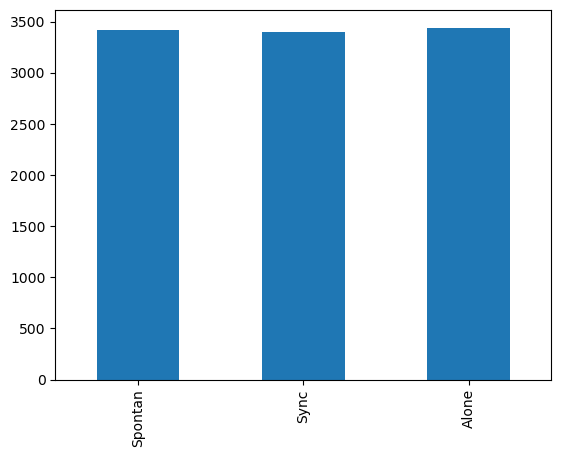

Spontan    3420
Sync       3403
Alone      3444
Name:  Position X, dtype: int64


In [15]:
# chack if the data is balanced
Labels_count = df.groupby('Label').count()[" Position X"]
Labels_count.index = ["Spontan","Sync","Alone"]
Labels_count.plot.bar()
plt.show()
print(Labels_count)

# modeling

In [16]:
Y = df['Label']
X = df.drop('Label', axis=1)

In [17]:
#split x and y to trin and test
x_train , x_test , y_train , y_test = split(X,Y ,train_size = 0.8 , shuffle = True , random_state = 1)

In [18]:
#scal data
scal_x_train = pd.DataFrame(StandardScaler().fit(x_train).transform(x_train),columns=X.columns)
scal_x_test = pd.DataFrame(StandardScaler().fit(x_train).transform(x_test),columns=X.columns)

## LogisticRegressionCV

Is a class that implements cross-validation inside it. This class will train multiple
LogisticRegression models and return the best one.  

## Random forest

Like its name implies, consists of a large number of individual decision trees that operate as an ensemble.  
Each individual tree in the random forest spits out a class prediction and the class with the most votes becomes our model prediction.

## Naive Bayes

Methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable.

(I explained AdaBoost and xgboost in notebook 1)

In [19]:
# models:
LRCV =  LogisticRegressionCV(cv=5, random_state=0)
RF = RandomForestClassifier(max_depth=1)
NB = GaussianNB()
ADA = AdaBoostClassifier(n_estimators = 100)
XG = XGBClassifier(n_estimators= 200, n_jobs=-1, learning_rate=0.4, seed=0, eval_metric = 'mlogloss')

## Voting

Trains on number of models and predicts an output based on their highest probability of chosen class as the output.

**Hard** voting, the predicted output class is a class with the highest majority of votes . 

**Soft** voting, the output class is the prediction based on the average of probability given to that class.

In [20]:
estimator_list = [
    ('LRCV',LRCV),
    ('RF',RF),
    ('NB',NB),
    ('ADA',ADA),
    ('XG',XG) ]

VC = VotingClassifier(estimators=estimator_list , voting='soft')

## stacking 

Combines multiple classification models via a meta-classifier(or blender). The base level models are trained based on a complete training set, then the meta-model is trained on the outputs of the base level model as features.

In [21]:
estimator_list = [
    ('LRCV',LRCV),
    ('RF',RF),
    ('NB',NB),
    ('ADA',ADA),
    ('XG',XG),
    ('VC',VC)]



ST = StackingClassifier(estimators=estimator_list , final_estimator=XG )
Models = [LRCV,RF,NB,ADA,XG,VC,ST]

In [22]:
score = []
for model in Models:
    model.fit(scal_x_train, y_train)
    print('.')
    score.append(model.score(scal_x_test,y_test))
scores = pd.DataFrame(data=score  , index=['Logstic Regression CV','Random Forest', 'Naive Bayes', 'AdaBoost', 'xgboost', 'voting','Stacking'], columns= ['score'])
scores

.
.
.
.
.
.
.


,score
Logstic Regression CV,0.892405
Random Forest,0.759007
Naive Bayes,0.866602
AdaBoost,0.676241
xgboost,0.984421
voting,0.947420
Stacking,0.980039


### We can see that xgboost is the best model with 98.44% ! 

## Lats try use PCA with xgboost

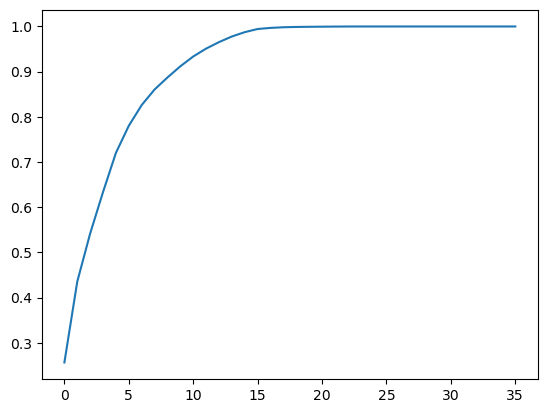

In [23]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.show()

In [24]:
pca = PCA(n_components=0.95)
x_trin_new =  pca.fit_transform(scal_x_train)
x_test_new = pca.transform(scal_x_test)

In [25]:
print("Size befor PCA" + str(x_train.shape))
print("Size after PCA" + str(x_trin_new.shape))

Size befor PCA(8213, 36)
Size after PCA(8213, 22)


In [26]:
score = []
for model in Models:
    model.fit(x_trin_new, y_train)
    score.append(model.score(x_test_new,y_test))
scores = pd.DataFrame(data=score  , index=['Logstic Regression CV','Random Forest', 'Naive Bayes', 'AdaBoost', 'xgboost','voting','Stacking'], columns= ['score after PCA'])
scores

,score after PCA
Logstic Regression CV,0.872444
Random Forest,0.797955
Naive Bayes,0.865141
AdaBoost,0.806232
xgboost,0.957157
voting,0.943525
Stacking,0.952775


### PCA helped us to reduce the features from 32 to 22 but our best score go from 98.44 to 95.7 so we will stay with xgboost without PCA.

In [27]:
XG.fit(scal_x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.4, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=0,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

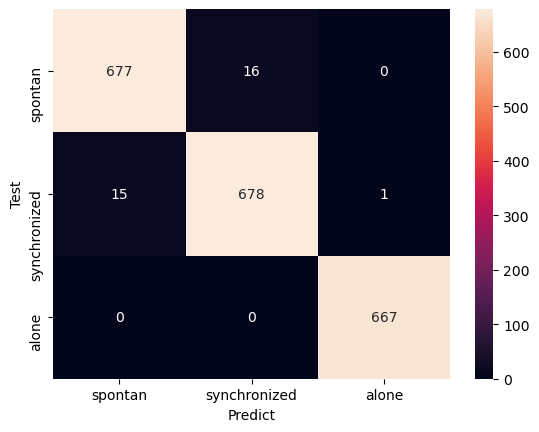

In [28]:
y_pred = XG.predict(scal_x_test)
cm = confusion_matrix(y_test, XG.predict(scal_x_test))
index = ['spontan', 'synchronized', 'alone']
columns = ['spontan', 'synchronized', 'alone']
cm_pd = pd.DataFrame(data =cm, index=index, columns=columns)
sns.heatmap(cm_pd,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

In [29]:
print("xgboost report on trining data")
print(classification_report(y_test,y_pred))

xgboost report on trining data
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       693
         1.0       0.98      0.98      0.98       694
         2.0       1.00      1.00      1.00       667

    accuracy                           0.98      2054
   macro avg       0.98      0.98      0.98      2054
weighted avg       0.98      0.98      0.98      2054



# validation:

In [30]:
valid_folder = glob.glob(r'/Users/ortrabelsi/Desktop/מטלה דימות נתונים/Hand Positions/extraFiles/Validation' + "/*")
valid_df = Makedata(valid_folder)

# Delete all the data with 1 hand whan shuold be 2 
temp = valid_df[(valid_df[' # hands']!=1) | (valid_df['Label']==2)]
# Delete all the data with 2 hand whan shuold be 1
valid_df = temp[(temp[' # hands']==1 ) | (temp['Label']!=2)]


In [31]:
# Marge all the data again
valid_alone = make_Alone(valid_df)
valid_not_alone = Make_not_Alone(valid_df)

# final df
valid_df = pd.concat([valid_not_alone, valid_alone], axis=0, ignore_index=True)


# drop Irrelevant and take sample every 10 row
valid_df = valid_df.drop(['Time', ' Frame ID',' Hand Type',' # hands',' Hand Type_',' # hands_'
           ,' Frame ID_'], axis=1)
valid_df = valid_df[::10]
valid_df

,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,Yaw,Wrist Pos X,...,Yaw_,Wrist Pos X_,Wrist Pos Y_,Wrist Pos Z_,Elbow pos X_,Elbow Pos Y_,Elbow Pos Z_,Grab Strenth_,Grab Angle_,Pinch Strength_
0,-77.03016,199.2262,18.11893,-16.442820,-10.225020,-41.097580,1.442093,1.863396,-0.879181,-69.54090,...,-0.146604,132.513700,121.3219,29.08213,245.28540,-54.15136,159.4198,0.000000,0.000000,0.000000
10,-68.38531,194.1776,10.64774,97.638220,-73.340470,-57.033750,1.355775,1.781888,-0.090037,-70.37798,...,-0.171549,132.765800,122.7568,31.92996,270.65610,-17.81004,179.3187,0.000000,0.000000,0.000000
20,-39.87021,177.6306,-15.83130,29.425930,-138.186300,-11.259920,0.887065,1.891893,0.362533,-59.52320,...,-0.174270,131.688600,121.6800,32.80169,268.88430,-16.44120,183.1216,0.000000,0.000000,0.000000
30,-23.72169,153.9706,-37.27345,26.070390,-99.294820,-95.013860,0.498042,1.990777,0.441552,-55.90739,...,-0.152022,133.170000,123.6442,30.03172,259.98210,-24.29080,180.1323,0.000000,0.000000,0.000000
40,-30.30432,157.3541,-39.79742,-102.802600,95.621590,102.478900,0.381265,2.158751,0.536394,-67.56796,...,-0.142651,137.633600,128.5362,28.82718,239.14570,-51.49055,162.1760,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30060,-73.64055,236.5665,51.36557,9.622766,42.243240,67.983600,-0.450006,2.538746,1.006383,-130.65720,...,-0.651719,36.749980,233.0021,91.33095,207.46750,236.09410,302.9377,0.401809,1.496740,0.459398
30070,-75.49327,243.0455,59.35230,-49.257890,75.825950,8.991091,-0.138549,2.511795,0.961944,-132.07970,...,-0.513138,-4.576571,214.8401,65.96033,139.52710,86.49594,257.5156,0.000000,0.275622,0.000000
30080,-77.90935,259.5165,66.61760,-106.480300,-140.364500,63.737690,0.314622,1.560732,0.868023,-131.77540,...,0.311297,7.957485,200.8633,74.38482,36.32519,33.87052,287.0822,0.000000,0.393413,0.000000
30090,-76.36844,270.5079,84.37321,50.407720,99.490470,85.870850,0.721602,0.900617,0.927229,-128.67920,...,0.481921,30.895900,162.0289,69.58566,-12.39499,29.96926,303.2898,0.000000,0.489808,0.000000


In [32]:
valid_Y = valid_df['Label']
valid_X = valid_df.drop('Label', axis=1)

In [33]:
scal_x_test = pd.DataFrame(StandardScaler().fit(x_train).transform(valid_X),columns=X.columns)

In [34]:
print("My final mean score: " + str((XG.score(scal_x_test,valid_Y)*100).round(2))+ "%")

My final mean score: 88.44%


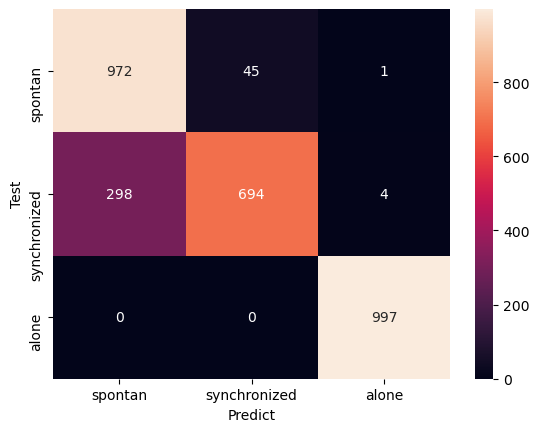

In [35]:
y_pred = XG.predict(scal_x_test)
cm = confusion_matrix(valid_Y, y_pred)
index = ['spontan', 'synchronized', 'alone']
columns = ['spontan', 'synchronized', 'alone']
cm_pd = pd.DataFrame(data =cm, index=index, columns=columns)
sns.heatmap(cm_pd,fmt=".0f", annot=True)
plt.xlabel("Predict")
plt.ylabel("Test")
plt.show()

In [36]:
print("xgboost report on trining data")
print(classification_report(valid_Y,y_pred))

xgboost report on trining data
              precision    recall  f1-score   support

         0.0       0.77      0.95      0.85      1018
         1.0       0.94      0.70      0.80       996
         2.0       1.00      1.00      1.00       997

    accuracy                           0.88      3011
   macro avg       0.90      0.88      0.88      3011
weighted avg       0.90      0.88      0.88      3011



# Conclusion

We can see that xgboost is the best model for this case.
I think that in this case we shouldn't use PCA becuse the difference in percentages is too significant.
The final result of our model is 88.44% on the validation data!
